In [1]:
import pygplates
import time as tme
import numpy as np
import pyvista as pv
from numba import jit
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.interpolate import interp1d
from scipy.spatial.distance import cdist
from CodeAfterFirstNotebook import Earth

In the previous notebook, we discussed how to move tectonic plates along a spherical earth. We will now discuss how we approximate various tectonic phenomina onto the earth, which will involve getting the distance and speeds that vertices are from the plate boundaries.

# Plate Boundaries

In calculating various tectonic forces, we will be needing data about various types of plate boundaries. We create a general *PlateBoundary* class, and two child-classes *SubductionBoundary* and *RidgeBoundary*. To initiate plate boundary, we will pass the *sharedBound* object obtained from the *pygplates* library, which reconstructs coordinates and other properties about plate boundaries.

The attribute *sharedPlateIds* contains the plate ids of neighbouring plates for each point on the plate boundary. In most cases, *pygplates* provides two plates as the neighbouring plates, however occasionally it will provide a different number of neighbouring plates. If *pygplates* doesn't provide exactly two neighbouring plates, then we will not include that particular plate boundary section, as it will only cause problems in our code later on.

In [2]:
#Define some parameters
platePolygonsDirectory = './dataPygplates/Matthews_etal_GPC_2016_MesozoicCenozoic_PlateTopologies_PMAG.gpmlz'
rotationsDirectory = './dataPygplates/Matthews_etal_GPC_2016_410-0Ma_GK07_PMAG.rot'
rotationModel = pygplates.RotationModel(rotationsDirectory)
earthRadius = 6378.137
time = 0

#Create a general plate boundary class
class PlateBoundary:
    def __init__(self, sharedBound):
        
        #Extract relevant data from sharedBounds
        lon, lat, sharedPlateIds = [], [], []
        for sharedSubSection in sharedBound.get_shared_sub_segments():
            latLon = sharedSubSection.get_resolved_geometry().to_lat_lon_array()
            
            #Get ids of neighbouring plates
            sharedId = []
            for i in sharedSubSection.get_sharing_resolved_topologies():
                idx = i.get_resolved_feature().get_reconstruction_plate_id()
                sharedId.append(idx)
            
            #Ignore plate boundaries with not exactly two neighbouring plates
            twoSharedIds =  (len(sharedId) == 2)
            if not twoSharedIds:
                continue
            
            #Append relevant data to lists
            for i in range(len(latLon)):
                lon.append(latLon[i, 1])
                lat.append(latLon[i, 0])
                sharedPlateIds.append(sharedId)
        
        #Store data as class attributes
        self.lon = np.array(lon)
        self.lat = np.array(lat)
        self.XYZ = Earth.polarToCartesian(earthRadius, self.lon, self.lat)
        self.sharedPlateIds = np.array(sharedPlateIds)
        self.boundType = 0
        self.gpmlBoundType = str(sharedBound.get_feature().get_feature_type())
        
        #These attributes will be set later
        self.lineCentres = np.zeros((self.XYZ.shape[0] - 1, 3))
        self.linePoints = np.zeros((self.XYZ.shape[0] - 1, 2, 3))
        self.collisionSpeed = np.zeros(self.XYZ.shape[0] - 1)
        self.speedDirection = np.zeros((self.XYZ.shape[0] - 1, 3))

#Create child class for subduction plate boundaries
class SubductionBoundary(PlateBoundary):
    def __init__(self, sharedBound):
        
        #Run the parent's initialization
        PlateBoundary.__init__(self, sharedBound)
        
        #Get plate ids of overriding plate and subducting plates
        overPlateId, subPlateId = [], []
        for sharedSubSection in sharedBound.get_shared_sub_segments():
            overAndSubPlates = sharedSubSection.get_overriding_and_subducting_plates(True)
            if (overAndSubPlates != None):
                overridingPlate, subductingPlate, subduction_polarity = overAndSubPlates
                overPlateId.append(overridingPlate.get_feature().get_reconstruction_plate_id())
                subPlateId.append(subductingPlate.get_feature().get_reconstruction_plate_id())
        
        #Save data
        self.overPateId = np.unique(overPlateId)
        self.subPlateId = np.unique(subPlateId)
        self.boundType = 1

#Create child class for ridge plate boundaries
class RidgeBoundary(PlateBoundary):
    def __init__(self, sharedBound):
        PlateBoundary.__init__(self, sharedBound)
        self.boundType = 2

Now that we have defined our classes, we create a function that makes use of *pygplates* to return a list of plate boundary objects at a specified time.

In [3]:
#Since we are ignoring plate boundaries with not exactly two neighbouring plates,
#Some plate boundaries will have no coordinates, so we ignore those
def ignoreThisBoundary(sharedBound):
    ignoreThis = True
    for s in sharedBound.get_shared_sub_segments():
        if len(s.get_sharing_resolved_topologies()) == 2:
            ignoreThis = False
    return ignoreThis

#Create function that returns a list of plate boundaries at specified times
def createPlateBoundariesAtTime(time,
                platePolygonsDirectory = './dataPygplates/Matthews_etal_GPC_2016_MesozoicCenozoic_PlateTopologies_PMAG.gpmlz',
                rotationsDirectory = './dataPygplates/Matthews_etal_GPC_2016_410-0Ma_GK07_PMAG.rot'):
    
    #Use pygplates to get shared boundary sections at specified time
    resolvedTopologies, sharedBoundarySections = [], []
    rotationModel = pygplates.RotationModel(rotationsDirectory)
    pygplates.resolve_topologies(platePolygonsDirectory, rotationModel, resolvedTopologies, time, sharedBoundarySections)
    
    #Loop through all shared plate boundaries
    plateBoundaries = []
    for sharedBound in sharedBoundarySections:

        #Identify which type of boundary this is
        boundType = sharedBound.get_feature().get_feature_type()
        isSubduction = boundType == pygplates.FeatureType.gpml_subduction_zone
        isOceanicRidge = boundType == pygplates.FeatureType.gpml_mid_ocean_ridge
        if ignoreThisBoundary(sharedBound):
            continue

        #Create plate boundary object of appropriate type and append to list of plate boundaries
        if isSubduction:
            plateBoundaries.append(SubductionBoundary(sharedBound))
        elif isOceanicRidge:
            plateBoundaries.append(RidgeBoundary(sharedBound))
        else:
            plateBoundaries.append(PlateBoundary(sharedBound))
            
    return plateBoundaries

The following function will be used for converting a list of plate boundary objects into a *pyvista* mesh of lines for better visualizations of the plate boundaries.

In [4]:
def getBoundaryLines(plateBounds):
    
    #Variables used to create the line pyvista object
    XYZ, lineConnectivity, bType = [], [], []
    
    #Counter for keeping track of how many vertices we have used
    xyzCount = 0
    
    #Loop through all plate boundaries
    for bound in plateBounds:
        
        #Create lineID for defining line connectivity
        numOfPoints = len(bound.XYZ)
        lineConnectivity.append(numOfPoints)
        lineID = np.arange(numOfPoints) + xyzCount
        
        #Loop through points in plate boundary and append to arrays
        for i in range(numOfPoints):
            lineConnectivity.append(lineID[i])
            XYZ.append(bound.XYZ[i])
            bType.append(bound.boundType)
        xyzCount += numOfPoints
        
    #Create the line mesh
    lineMesh = pv.PolyData(np.array(XYZ), lines=lineConnectivity)
    lineMesh['boundType'] = np.array(bType)
    return lineMesh

#Create mesh object for plotting
pBounds = createPlateBoundariesAtTime(10)
lineMesh = getBoundaryLines(pBounds)

#Plot the results
plotter = pv.PlotterITK()
plotter.add_mesh(pv.Sphere(radius=earthRadius-100))
plotter.add_mesh(lineMesh, scalars='boundType')
plotter.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

# Distance from Plate Boundaries

To apply various tectonic forces, we will need to know how far a vertex is from plate boundaries. A simple yet naiive solution would be to use the *scipy.spatial.cKDTree()* function to get the distances from sphere points to boundary points. Although this approach works well for sphere points which are fairly far from plate boundaries, it does not work well for points near the boundary regions, as demonstrated bellow. 

What we want to do instead, is to measure the distance from the line spanned by two boundary points.

In [5]:
#Create a sphere
sphere = pv.Sphere(radius=earthRadius, theta_resolution=400, phi_resolution=400)
sphereXYZ = sphere.points

#Create plate boundaries and get its XYZ coordinates
plateBounds = createPlateBoundariesAtTime(0)
boundMesh = getBoundaryLines(plateBounds)
boundXYZ = boundMesh.points

#Calculate distances from points
distances = cKDTree(boundXYZ).query(sphereXYZ)[0]

#Display results
plotter = pv.PlotterITK()
plotter.add_mesh(sphere, scalars=distances**0.25)
plotter.add_mesh(boundMesh, scalars='boundType')
plotter.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

We will now explain how we calculate a distance from a line with reference to the image bellow. Let $\textbf{s}$ be a point on the sphere, $\textbf{p}_1$ and $\textbf{p}_2$ be the two points spanning the boundary segments. In calculate the distance of $\textbf{s}$ from the line segment, there are 3 possible cases:

 - $\textbf{s}$ is closest to $\textbf{p}_1$
 - $\textbf{s}$ is closest to some point between $\textbf{p}_1$ and $\textbf{p}_2$
 - $\textbf{s}$ is closest to $\textbf{p}_2$
 
Let $\textbf{v} = \textbf{p}_2 - \textbf{p}_1$ and $\textbf{w} = \textbf{s} - \textbf{p}_1$, then we can check which case we are in with:

- Case 3: $\textbf{w} \cdot \textbf{v} <= 0$
- Case 1: If not case 3 and $\textbf{v} \cdot \textbf{v} <= \textbf{w} \cdot \textbf{v}$
- Case 2: Otherwise

Incase the reader may be unfamiliar with the dot product, taking the dot product of a vector with $\textbf{v}$ gives the magnitude of the projection of the vector onto $\textbf{v}$. Once we have identified which case we are in, we can make the appropriate distance calculation.

<div>
<img src="files/Images/ClosestToLineCropped2.png" width="600">
</div>

We split this task into 3 function and *getDistsToBounds()* will be the main function we call. It will use *prepareLines()* to get the centres and the points $\textbf{p}_1$ and $\textbf{p}_2$. We use *cKDTree()* to get the index of the closest line centres for each point on the sphere, which can be used to get the appropriate $\textbf{p}_1$ and $\textbf{p}_2$. We then use *getDistsToLinesSeg()* to calculate the appropriate distance as explained above. 

Since the function *getDistsToLinesSeg()* is slow, we use the *@jit(nopython=True)* decorator from the *numba* library to significantly speed things up. Although this decorator poses many restrictions on the content of the function such that we can not use many libraries apart from numpy, it speeds up our calculation by 10 times the speed. It is also a good habit to get into since it allows for GPU acceleration and can sometimes speed python code by 1000 times. If *numba* is not installed in your system, just uncomment the decorator and the function should run as normal, but slower.

In [6]:
#Get line centres and points spanning each line
def prepareLines(plateBounds):
    lineCentres, linePoints = [], []
    for bound in plateBounds:
        for i in range(bound.XYZ.shape[0]-1):
            point1 = bound.XYZ[i]
            point2 = bound.XYZ[i+1]
            lineCentres.append((point1 + point2) / 2)
            linePoints.append([point1, point2])
    return np.array(lineCentres), np.array(linePoints)

#Get distance from line segments
@jit(nopython=True)
def getDistsToLinesSeg(sphereXYZ, closestLinePoints):
    distToBound = np.zeros(sphereXYZ.shape[0])
    directionToBound = np.zeros((sphereXYZ.shape[0], 3))
    for i in range(sphereXYZ.shape[0]):
        linePoints = closestLinePoints[i]
        xyz = sphereXYZ[i]

        #Append distance from vertex 0
        v = linePoints[1] - linePoints[0]
        w = xyz - linePoints[0]
        if np.dot(w, v) <= 0:
            distToZero = np.linalg.norm(linePoints[0] - xyz)
            distToBound[i] = distToZero
            directionToBound[i] = (linePoints[0] - xyz) / distToZero

        #Append distance from vertex 1  
        elif np.dot(v, v) <= np.dot(w, v):
            distToOne = np.linalg.norm(linePoints[1] - xyz)
            distToBound[i] = distToOne
            directionToBound[i] = (linePoints[1] - xyz) / distToOne

        #Append distance from somewhere in the line centre
        else:
            numerator = np.linalg.norm(np.cross(linePoints[1] - xyz, linePoints[1] - linePoints[0]))
            denominator = np.linalg.norm(linePoints[1] - linePoints[0])
            distToLine = numerator / denominator
            distToBound[i] = distToLine
            
            linePerpDirection = np.cross(xyz, linePoints[1] - linePoints[0])
            directionToBound[i] = linePerpDirection / np.linalg.norm(linePerpDirection)
    return distToBound, directionToBound

#Main function to call to get distance from plate boundaries
def getDistsToBounds(plateBounds, sphereXYZ):
    lineCentres, linePoints = prepareLines(plateBounds)
    distIds = cKDTree(lineCentres).query(sphereXYZ)[1]
    closestLinePoints = linePoints[distIds]
    distToBound, directionToBound = getDistsToLinesSeg(sphereXYZ, closestLinePoints)
    return distToBound

As we can see bellow, we now have much cleaner distances to plate boundaries.

In [7]:
#Run the newly defined functions
distToBound = getDistsToBounds(plateBounds, sphereXYZ)

#Display results
plotter = pv.PlotterITK()
plotter.add_mesh(sphere, scalars=distToBound**0.25)
plotter.add_mesh(boundMesh, scalars='boundType')
plotter.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

# Speed of Collision

In order to approximate forces such as subduction uplift or ocean floor formation, we will require the speed at which plates converge or diverge. We will use positive speeds to represent converging plate boundaries and negative speeds to represent diverging plate boundaries. We will use the term *velocity* in the context of vectors (direction and magnitude) and *speed* as only the magnitude of the velocity.

Velocity$\textbf{v}$ is defined as the rate of change in position $\textbf{x}$, given by:

$$
\textbf{v} = \frac{\delta \textbf{x}}{\delta t}
$$

Here $\delta t$ is simply the chage in time at each iteration of our simulation. To calculate $\delta \textbf{x}$ for any point $\textbf{x}$ on a plate boundary, we apply rotations $r_0$ and $r_1$ on $\textbf{x}$ from plates on either sides of the plate boundary, and the change in position can be calculated by:

$$
\delta \textbf{x} = r_1(\textbf{x}) - r_0(\textbf{x})
$$

The speed $s$ can then be obtained by taking the vector norm of the velocit $\| \textbf{v} \|$.

To assign each speed a positive or negative coefficient representing convergence or divergence, we apply rotations $r_0$ and $r_1$ to the plate centres $\textbf{c}_0$ and $\textbf{c}_1$ of plates on either sides of the boundary, and see if they moved closer or further away from each other. In other words, we set the speed to negative if:

$$
\| \textbf{c}_1 - \textbf{c}_0 \| < \| r_1(\textbf{c}_1) - r_0(\textbf{c}_0) \|
$$

The plate centres are calculated as the average position of all vertices on that plate.

In [8]:
#Create a dictionary containing plate Ids as keys and plate centres as values
def getPlateCentres(sphereXYZ, plateIds):
    plateCentres = {}
    uniqueIds = np.unique(plateIds)
    for i in range(uniqueIds.shape[0]):
        plateXYZ = sphereXYZ[plateIds==uniqueIds[i]] * earthRadius
        plateCentres[uniqueIds[i]] = np.sum(plateXYZ, axis=0) / plateXYZ.shape[0]
    return plateCentres

#Calculate the speed of collisions
def getCollisionsSpeeds(boundXYZ, sharedPlateIds, rotations, plateCentres, deltaTime):
    speeds = np.zeros(boundXYZ.shape[0])
    directions = np.zeros((boundXYZ.shape[0], 3))
    speedDirection = np.zeros((boundXYZ.shape[0], 3))
    for i in range(boundXYZ.shape[0]):
        bXYZ = boundXYZ[i]
        shareId = sharedPlateIds[i]
        
        #Some tectonic plates are so small that we don't have any vertices representing it
        #Therefore, some sharedIds might not have rotations or plate centres defined for it
        #In this case we simply set the speed to 0 and ignore the rest of this function
        if not np.all(np.isin(shareId, list(rotations.keys()))):
            continue
        
        #Calculate speed based on distance moved by rotations
        rot0 = rotations[shareId[0]]
        rot1 = rotations[shareId[1]]
        movedXyz0 = rot0.apply(bXYZ)
        movedXyz1 = rot1.apply(bXYZ)
        velocity = (movedXyz1 - movedXyz0) / deltaTime
        speed = np.linalg.norm(velocity)
        if speed != 0:
            directions[i] = velocity / speed
        
        #Identify if this boundary segment belongs to a converging or diverging boundary
        #Then set speed to positive or negative value accordingly
        cent0 = plateCentres[shareId[0]]
        cent1 = plateCentres[shareId[1]]
        centDist = np.linalg.norm(cent1 - cent0)
        centDistAfter = np.linalg.norm(rot1.apply(cent1) - rot0.apply(cent0))
        if centDist < centDistAfter:
            speed = -speed
        speeds[i] = speed
    return speeds, directions

To insure that our data arrays for speeds is compatible with our distance calculations, we will source our speeds from plate boundary line centres. So we modify the *prepareLines()* function to now include an array of sharedIds.

In [9]:
#We set the collision speed attribute for points in our plate boundary objects
def setCollisionSpeeds(plateBounds, rotations, plateCentres, deltaTime):
    for bound in plateBounds:
        for i in range(bound.XYZ.shape[0]-1):
            point1 = bound.XYZ[i]
            point2 = bound.XYZ[i+1]
            bound.lineCentres[i] = (point1 + point2) / 2
            bound.linePoints[i, 0] = point1
            bound.linePoints[i, 1] = point2
        speeds, directions = getCollisionsSpeeds(
            bound.lineCentres, 
            bound.sharedPlateIds[:-1], 
            rotations, 
            plateCentres, 
            deltaTime)
        bound.collisionSpeed = speeds
        bound.speedDirection = directions
    return plateBounds

#Returns arrays of all boundary XYZ and speeds
def getSpeedsData(plateBounds):
    boundCentXYZ, speeds, directions = [], [], []
    for bound in plateBounds:
        for i in range(bound.XYZ.shape[0]-1):
            boundCentXYZ.append(bound.XYZ[i])
            speeds.append(bound.collisionSpeed[i])
            directions.append(bound.speedDirection[i])
    return np.array(boundCentXYZ), np.array(speeds), np.array(directions)

#Create pyvista mesh objects for plotting
def getSpeedsMesh(boundCentXYZ, speeds, scale=600):
    arrow = pv.Arrow(start=(-0.5, 0.0, 0.0))
    boundMesh = pv.PolyData(boundCentXYZ * 1.05)
    boundMesh['direction'] = boundCentXYZ
    boundMesh['size'] = speeds / np.max(speeds)
    speedVectors = boundMesh.glyph(geom=arrow, orient='direction', scale='size', factor=scale)
    return speedVectors

#Create mesh object for visualizing the direction of collisions
def getSpeedDirectionsMesh(boundCentXYZ, directions, scale=300):
    cylinder = pv.Cylinder(radius=0.02)
    boundMesh = pv.PolyData(boundCentXYZ * 1.05)
    boundMesh['direction'] = directions
    directionMesh = boundMesh.glyph(geom=cylinder, orient='direction', factor=scale)
    return directionMesh

In [10]:
#Specify the date to consider for our data
time = 5 #Million Years Ago

#Use the imported code based on the previous tutorial to get relevant earth data
earth = Earth(startTime=time)
plateIds = earth.getPlateIdsAtTime(time)
rotations = earth.getRotations(plateIds, time)
sphereXYZ = earth.sphereXYZ * earth.earthRadius
plateCentres = getPlateCentres(sphereXYZ, plateIds)

#Calculate collisions speeds
plateBounds = createPlateBoundariesAtTime(time)
plateBounds = setCollisionSpeeds(plateBounds, rotations, plateCentres, earth.deltaTime)
boundCentXYZ, speeds, directions = getSpeedsData(plateBounds)

#Create mesh objects for plotting
speedMesh = getSpeedsMesh(boundCentXYZ, speeds)
directionMesh = getSpeedDirectionsMesh(boundCentXYZ, directions)
exageratedRadius = 30 * earth.heightHistory[0] + earth.earthRadius
earthMesh = pv.PolyData((earth.sphereXYZ.T * exageratedRadius).T, earth.earthFaces)

#Display results
plotter = pv.PlotterITK()
plotter.add_mesh(earthMesh, scalars=earth.heightHistory[0])
plotter.add_mesh(speedMesh)
plotter.add_mesh(directionMesh)
plotter.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

# Subduction Uplift

When two tectonic plates collide, one will typically submerge underneath the other, pushing the overriding plate upwards which leads to mountain growth. The class *SubductionBoundary* which contains list of overriding and subducting plates which can be used to identify which plate to apply subduction uplift onto, which corresponds to the overriding plates.

To calculate the change in height $\delta h$ we should apply to overriding vertices, we will consider:

- $f(d)$: The distance $d$ an overriding vertex is from the subduction boundary
- $g(s)$: The speed $s$ at which nearby subduction boundaries are colliding with
- The current height of the vertex

We will refer to each contribution as the distance, speed and height transfers.

Note that for simplification purposes, we will treat orogenic belts (continental collision) as a subduction boundary where both sides of the boundary are considered to be overriding plates.

### Distance Transfer

To create the distance transfer, we will create some template points to draw the distance transfer $f(d)$ with. We will then use the quadratic 1 dimensional interpolation scheme *scipy.interpolate.interp1d()* to convert these points into a continuous function. When specifying these template points, the main features of the function should be kept within a range of $d$ and $f \in [0, 1]$, so that the effective range of the distance transfer can be specified by $\alpha$, which can be applied by using $f(\frac{d}{\alpha})$. 

Note that we will also be passing distances to $f(\frac{d}{\alpha})$ which fall outside the range of $[0, 1]$. To avoid crashing the *interp1d()* function, we will return 0 for those values. Also, since *interp1d()* fits a quadratic polynomial to the template points, we need to confirm that the resulting polynomial looks as desired by plotting it, otherwise we may get unexpected swings in the template curve.

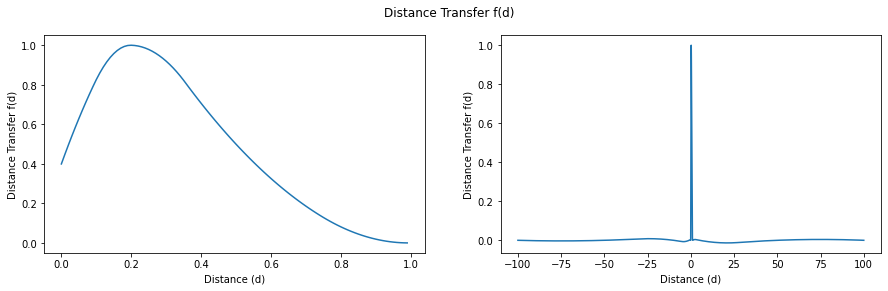

In [11]:
#Template curve for the distance transfer for subduction uplift
distTransPoints = np.array([
    [-100, 0.0],
    [-50, 0],
    [-10, 0],
    [-1.0, 0.0],
    [-0.101, 0.0],
    [-0.1, 0.0],
    [0, 0.4],
    [0.19, 1.0],
    [0.21, 1.0],
    [0.5, 0.5],
    [0.99, 0.0],
    [1.0, 0.0],
    [5.0, 0.0],
    [50.0, 0.0],
    [100.0, 0.0]
    ])
distanceTransfer = interp1d(distTransPoints[:, 0], distTransPoints[:, 1], kind='quadratic')

fig, axs = plt.subplots(1, 2, figsize=(15,4))
fig.suptitle('Distance Transfer f(d)')

d = np.arange(0, 1, 0.01)
f = distanceTransfer(d)
axs[0].plot(d, f)
axs[0].set(xlabel='Distance (d)', ylabel='Distance Transfer f(d)')

d = np.arange(-100, 100, 0.01)
f = distanceTransfer(d)
axs[1].plot(d, f)
axs[1].set(xlabel='Distance (d)', ylabel='Distance Transfer f(d)')
plt.show()

For the sake of subduction uplift, we only want to measure distances from vertices to the subduction boundaries where this plate is overriding on. In other words, for a given plate, we don't want to measure distances to boundaries where this plate is subducting. To achieve this, we create a dictionay that has plateIds as keys, and returns the appropriate plateBoundary objects. We then loop through each plate Id on our earth, and use the dictionary to calculate distance from the appropriate plate boundaries.

In [12]:
#Create dictionary with plate ids as keys and the plate's subduction boundary as values
def getSubductionBoundsForEachPlateId(plateBounds):
    idToSubBound = {}
    for bound in plateBounds:
        
        #List to store plate ids of overriding plates for this boundary
        overId = []
        
        #Append plate ids of overiding plates
        if bound.boundType == 1:
            for idx in bound.overPateId:
                overId.append(idx)
        
        #Append plate ids of both sides of an orogenic belt
        elif bound.gpmlBoundType == 'gpml:OrogenicBelt':
            for sIds in bound.sharedPlateIds:
                for idx in sIds:
                    overId.append(idx)
        
        #We append this plate boundary to dictionary values with appropriate keys (plateIds)
        overId = np.unique(overId)
        for idx in overId:
            if (idx not in list(idToSubBound.keys())):
                idToSubBound[idx] = []
            idToSubBound[idx].append(bound)
    return idToSubBound

#Using this dictionary, we can now measure the appropriate distances
#The default distance will be zero
def getDistanceToSubductionBoundary(sphereXYZ, plateIds, idToSubBound):
    distToSub = np.zeros(sphereXYZ.shape[0])
    for idx in np.unique(plateIds):
        if (idx not in idToSubBound.keys()):
            continue
        
        #Get the appropriate distance for vertices on this plate
        subBounds = idToSubBound[idx]
        xyzOnThisPlate = sphereXYZ[plateIds == idx]
        dists = getDistsToBounds(subBounds, xyzOnThisPlate)
        distToSub[plateIds == idx] = dists
    return distToSub

#We provide a demonstration of the distance transfer
distTransRange = 2000
idToSubBound = getSubductionBoundsForEachPlateId(plateBounds)
distToSub = getDistanceToSubductionBoundary(sphereXYZ, plateIds, idToSubBound)
distTrans = distanceTransfer(distToSub / distTransRange)
distTrans[distToSub <= 0] = 0

#Visualise the results
plotter = pv.PlotterITK()
plotter.add_mesh(earthMesh, scalars=distTrans)
plotter.add_mesh(boundMesh, scalars='boundType')
plotter.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

### Speed Transfer

A simple yet naive approach for applying the speed transfer is:
1. For each vertex on a given plate, find the closest valid subduction boundary
2. Set the speed of each vertex to that of the closest subduction boundary

However, theres a problem with this approach as demonstrated bellow. Calculating speeds in this way results in 'jumps' in the speed transfer. One region of a plate might have a single common closest subduction boundary, and a neighbouring region might have a common closest subduction boundary with a completely different speeds. At the transition of these two regions, the speed transfer will form a 'jump' in speed, which isn't realistic.

In [16]:
#Loop through each plate on our sphere
speedTrans = np.zeros(sphereXYZ.shape[0])
for idx in np.unique(plateIds):
    if (idx not in idToSubBound.keys()):
        continue
    
    #For each plate, get appropriate boundary data
    boundXYZ, boundSpeed = [], []
    for bound in idToSubBound[idx]:
        for i in range(bound.lineCentres.shape[0]):
            boundXYZ.append(bound.lineCentres[i])
            boundSpeed.append(bound.collisionSpeed[i])
    boundSpeed = np.array(boundSpeed)

    #Get the distance from vertices to plate boundaries for this plate
    xyzOnThisPlate = sphereXYZ[plateIds == idx]
    distIds = cKDTree(boundXYZ).query(xyzOnThisPlate)[1]
    speedTrans[plateIds == idx] = boundSpeed[distIds]

#Display the results
plotter = pv.PlotterITK()
plotter.add_mesh(earthMesh, scalars=speedTrans)
plotter.add_mesh(boundMesh, scalars='boundType')
plotter.add_mesh(speedMesh)
plotter.add_mesh(directionMesh)
plotter.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

To avoid these sudden jumps in speed transfers, we will find the closest $N$ subduction boundary coordinates, and our speed transfers will be based on an average of the collisions speeds of those $N$ boundaries. Since we are now finding the distances between plate vertices and  multiple plate boundaries instead of just one, we modify our distance calculation function from above so that the array *closestLinePoints* can now have a shape of (n, N, 2, 3), where n is the number of plate vertices. 

In [17]:
#Get distance from line segments
@jit(nopython=True)
def getMultipleDistsToLinesSeg(XYZ, closestLinePoints):
    distToBound = np.zeros((XYZ.shape[0], closestLinePoints.shape[1]))
    directionToBound = np.zeros((XYZ.shape[0], closestLinePoints.shape[1], 3))
    for i in range(XYZ.shape[0]):
        linePoints = closestLinePoints[i]
        xyz = XYZ[i]

        #Append distance from vertex 0
        v = linePoints[:, 1] - linePoints[:, 0]
        w = xyz - linePoints[:, 0]
        
        for j in range(w.shape[0]):
            if np.dot(w[j], v[j]) <= 0:
                distToZero = np.linalg.norm(linePoints[j, 0] - xyz)
                distToBound[i, j] = distToZero
                directionToBound[i, j] = (linePoints[j, 0] - xyz) / distToZero

            #Append distance from vertex 1  
            elif np.dot(v[j], v[j]) <= np.dot(w[j], v[j]):
                distToOne = np.linalg.norm(linePoints[j, 1] - xyz)
                distToBound[i, j] = distToOne
                directionToBound[i] = (linePoints[j, 1] - xyz) / distToOne

            #Append distance from somewhere in the line centre
            else:
                numerator = np.linalg.norm(np.cross(linePoints[j, 1] - xyz, linePoints[j, 1] - linePoints[j, 0]))
                denominator = np.linalg.norm(linePoints[j, 1] - linePoints[j, 0])
                distToLine = numerator / denominator
                distToBound[i, j] = distToLine

                linePerpDirection = np.cross(xyz, linePoints[j, 1] - linePoints[j, 0])
                directionToBound[i, j] = linePerpDirection / np.linalg.norm(linePerpDirection)
    return distToBound, directionToBound

In [32]:
numToAverage = 10

#Loop through each plate on our sphere
speedTrans = np.zeros(sphereXYZ.shape[0])
for idx in np.unique(plateIds):
    if (idx not in idToSubBound.keys()):
        continue
    
    #For each plate, get appropriate boundary data
    boundXYZ, boundSpeed = [], []
    for bound in idToSubBound[idx]:
        for i in range(bound.lineCentres.shape[0]):
            boundXYZ.append(bound.lineCentres[i])
            boundSpeed.append(bound.collisionSpeed[i])
    boundSpeed = np.array(boundSpeed)

    #Get the distance from vertices to plate boundaries for this plate
    xyzOnThisPlate = sphereXYZ[plateIds == idx]
    distIds = cKDTree(boundXYZ).query(xyzOnThisPlate, k=numToAverage)[1]
    distIds[distIds >= boundSpeed.shape[0]] = boundSpeed.shape[0]-1 #Avoid 'index out of bounds error'
    
    boundSpeed = boundSpeed[distIds]
    speedTrans[plateIds == idx] = np.sum(boundSpeed, axis=1) / numToAverage

#Display the results
plotter = pv.PlotterITK()
plotter.add_mesh(earthMesh, scalars=speedTrans)
plotter.add_mesh(boundMesh, scalars='boundType')
plotter.add_mesh(speedMesh)
plotter.add_mesh(directionMesh)
plotter.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

(11525, 10, 2, 3)
(4053, 10, 2, 3)
(294, 10, 2, 3)
(9027, 10, 2, 3)
(78, 10, 2, 3)
(932, 10, 2, 3)
(526, 10, 2, 3)
(72, 10, 2, 3)
(43, 10, 2, 3)
(43, 10, 2, 3)
(446, 10, 2, 3)
(49, 10, 2, 3)
(201, 10, 2, 3)
(53, 10, 2, 3)
(28, 10, 2, 3)
(2, 10, 2, 3)
(12, 10, 2, 3)
(61, 10, 2, 3)
(63, 10, 2, 3)
(27, 10, 2, 3)
(3792, 10, 2, 3)
(13587, 10, 2, 3)
(17, 10, 2, 3)
(252, 10, 2, 3)
(75, 10, 2, 3)
(55, 10, 2, 3)
(10256, 10, 2, 3)


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

15223.010238160618


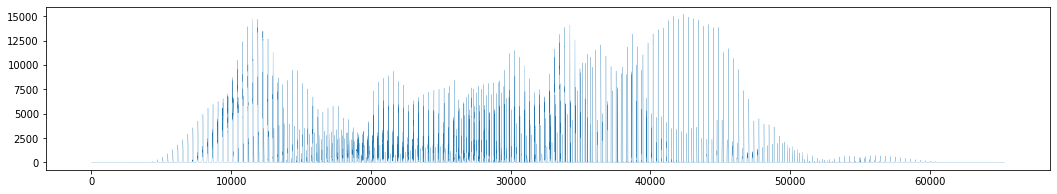

In [18]:
#Given a list of subduction boundaries, we extract relevant data and return as arrays
def getSubductionData(subBounds):
    boundXYZ, boundSpeed, boundDirection, linePoints = [], [], [], []
    for bound in subBounds:
        for i in range(bound.lineCentres.shape[0]):
            boundXYZ.append(bound.lineCentres[i])
            boundSpeed.append(bound.collisionSpeed[i])
            boundDirection.append(bound.speedDirection[i])
            linePoints.append(bound.linePoints[i])
    boundSpeed = np.array(boundSpeed)
    boundSpeed[boundSpeed < 0] = 0
    linePoints = np.array(linePoints)
    lineLengths = np.linalg.norm(linePoints[:, 0, :] - linePoints[:, 1, :], axis=1)
    return np.array(boundXYZ), boundSpeed, np.array(boundDirection), linePoints, lineLengths

#Calculates transfers one plate at a time
def getTransfersForThisPlate(idx, xyzOnThisPlate, plateIds, idToSubBound, numToAverageOver=80):
    boundXYZ, boundSpeed, boundDirection, linePoints, lineLengths = getSubductionData(idToSubBound[idx])
    
    #Get distances and the index array distIds
    distIds = cKDTree(boundXYZ).query(xyzOnThisPlate, k=numToAverageOver)[1]
    distIds[distIds >= boundXYZ.shape[0]] = boundXYZ.shape[0]-1 #Avoid 'index out of bounds error'
    closestLinePoints = linePoints[distIds]
    distToBound, directionToBound = getMultipleDistsToLinesSeg(xyzOnThisPlate, closestLinePoints)
    
    #'distIds' contains the indices of the N closest boundaries for each vertex XYZ on this plate
    boundSpds = boundSpeed[distIds]
    lineLngths = lineLengths[distIds]
    boundDirs = boundDirection[distIds]
    
    #Main transfer calculations
    speedTrans = np.zeros((numToAverageOver, xyzOnThisPlate.shape[0]))
    angleTrans = np.zeros((numToAverageOver, xyzOnThisPlate.shape[0]))
    for j in range(numToAverageOver):
        angle = np.einsum('ij,ij->i', directionToBound[:, j], boundDirs[:, j])
        speedTrans[j] = np.abs(boundSpds[:, j] * angle * lineLngths[:, j])
        angleTrans[j] = np.abs(angle)
    return speedTrans, angleTrans, distToBound[:, 0]

#Calculates transfers for all plates on the sphere
def getTransfers(sphereXYZ, plateIds, idToSubBound, numToAverageOver=80, distTransRange=1000):
    speedTransfer, angleTransfer = np.zeros(sphereXYZ.shape[0]), np.zeros(sphereXYZ.shape[0])
    distToSubBounds = np.zeros(sphereXYZ.shape[0])
    for idx in np.unique(plateIds):
        if (idx not in idToSubBound.keys()):
            continue
        xyzOnThisPlate = sphereXYZ[plateIds == idx]
        speedTrans, angleTrans, distToBound = getTransfersForThisPlate(idx, xyzOnThisPlate, plateIds, idToSubBound, 
                                                                       numToAverageOver=numToAverageOver)
        speedTransfer[plateIds==idx] = np.sum(speedTrans, axis=0) / numToAverageOver
        angleTransfer[plateIds==idx] = np.sum(angleTrans, axis=0) / numToAverageOver
        distToSubBounds[plateIds==idx] = distToBound
    
    #Calculate the distance transfer
    dTransInput = distToSubBounds / (distTransRange * angleTransfer + 0.01)
    dTransInput[dTransInput>=100] = 100
    dTransInput[dTransInput<= -100] = -100
    distTransfer = distanceTransfer(dTransInput) * (dTransInput <= 1.01)
    return speedTransfer, distTransfer

#Using our calculated transfers, we calculate the subduction uplift
def getTectonicUplift(sphereXYZ, plateIds, idToSubBound, numToAverageOver=80, distTransRange=1000):
    speedTransfer, distTransfer = getTransfers(sphereXYZ, plateIds, idToSubBound, 
                                             numToAverageOver=numToAverageOver, 
                                             distTransRange=distTransRange)
    #Calculate the tectonic uplifts and return results
    uplifts = distTrans * speedTransfer
    uplifts[uplifts <= 0.0001] = 0.0001
    return uplifts

numToAverageOver = 10
distTransRange = 1000
uplifts = getTectonicUplift(sphereXYZ, plateIds, idToSubBound, 
                            numToAverageOver=numToAverageOver, distTransRange=distTransRange)


#Visualise the results
plotter = pv.PlotterITK()
plotter.add_mesh(earthMesh, scalars=uplifts)
plotter.add_mesh(boundMesh, scalars='boundType')
plotter.add_mesh(speedMesh)
plotter.add_mesh(directionMesh)
plotter.show()

print(np.max(uplifts))
plt.figure(figsize=(18, 3))
plt.plot(uplifts, linewidth=0.2)
plt.show()

In [ ]:
#idToSubBound
numToAverageOver = 80
distTransRange = 1000

speedTransfer = np.zeros(sphereXYZ.shape[0])
uplift = np.zeros(sphereXYZ.shape[0])
for idx in np.unique(plateIds):
    if (idx not in idToSubBound.keys()):
        continue
    
    #Get the appropriate distance for vertices on this plate
    subBounds = idToSubBound[idx]
    xyzOnThisPlate = sphereXYZ[plateIds == idx]
    
    #Create relevant data array
    boundXYZ, boundSpeed, boundDirection = [], [], []
    linePoints = []
    for bound in subBounds:
        for i in range(bound.lineCentres.shape[0]):
            boundXYZ.append(bound.lineCentres[i])
            boundSpeed.append(bound.collisionSpeed[i])
            boundDirection.append(bound.speedDirection[i])
            linePoints.append(bound.linePoints[i])
    boundXYZ, boundSpeed, boundDirection = np.array(boundXYZ), np.array(boundSpeed), np.array(boundDirection)
    boundSpeed[boundSpeed < 0] = 0
    linePoints = np.array(linePoints)
    lineLengths = np.linalg.norm(linePoints[:, 0, :] - linePoints[:, 1, :], axis=1)
    
    #Get distances
    distIds = cKDTree(boundXYZ).query(xyzOnThisPlate, k=numToAverageOver)[1]
    distIds[distIds >= boundXYZ.shape[0]] = boundXYZ.shape[0]-1
    closestLinePoints = linePoints[distIds]
    distToBound, directionToBound = getMultipleDistsToLinesSeg(xyzOnThisPlate, closestLinePoints)
    
    #Index data arrays
    boundDirs = boundDirection[distIds]
    boundSpds = boundSpeed[distIds]
    lineLngths = lineLengths[distIds]
    
    #Main uplift calculations
    uplifts = np.zeros((numToAverageOver, xyzOnThisPlate.shape[0]))
    for j in range(numToAverageOver):
        angle = np.einsum('ij,ij->i', directionToBound[:, j], boundDirs[:, j])
        speedTrans = np.abs(boundSpds[:, j] * angle)
        if np.max(speedTrans) == 0:
            continue
        speedTransNormalized = speedTrans / np.max(speedTrans)
        distTrans = distanceTransfer(distToBound[:, j] * speedTransNormalized / distTransRange) * (distToBound[:, j] < 2 * distTransRange)
        uplifts[j] = speedTrans * lineLngths[:, j] * distTrans
    
    if np.max(speedTrans) == 0:
        continue
    speedTrans = np.abs(boundSpds[:, 0] * angle)
    speedTransNormalized = speedTrans / np.max(speedTrans)
    distTrans = distanceTransfer(distToBound[:, 0] * speedTransNormalized / distTransRange) * (distToBound[:, 0] < 2 * distTransRange)
    
    #uplift[plateIds == idx] = np.sum(uplifts, axis=0) * distTrans / (numToAverageOver)

speedTransfer[speedTransfer < 0] = 0


distToSub = getDistanceToSubductionBoundary(sphereXYZ, plateIds, idToSubBound)
distTrans = distanceTransfer(distToSub / (distTransRange * 2))
uplift *= distTrans
uplift[uplift <= 0] = 0.000001

#Visualise the results
plotter = pv.PlotterITK()
plotter.add_mesh(earthMesh, scalars=uplift**0.25)
plotter.add_mesh(boundMesh, scalars='boundType')
plotter.add_mesh(speedMesh)
plotter.add_mesh(directionMesh)
plotter.show()

In [ ]:
ewffewfewfew

In [ ]:
#idToSubBound
speedTransfer = np.zeros(sphereXYZ.shape[0])
uplift = np.zeros(sphereXYZ.shape[0])
for idx in np.unique(plateIds):
    if (idx not in idToSubBound.keys()):
        continue
    
    #Get the appropriate distance for vertices on this plate
    subBounds = idToSubBound[idx]
    xyzOnThisPlate = sphereXYZ[plateIds == idx]
    
    boundXYZ, boundSpeed, boundDirection = [], [], []
    linePoints = []
    for bound in subBounds:
        for i in range(bound.lineCentres.shape[0]):
            boundXYZ.append(bound.lineCentres[i])
            boundSpeed.append(bound.collisionSpeed[i])
            boundDirection.append(bound.speedDirection[i])
            linePoints.append(bound.linePoints[i])
            
    boundXYZ, boundSpeed, boundDirection = np.array(boundXYZ), np.array(boundSpeed), np.array(boundDirection)
    linePoints = np.array(linePoints)
    
    distIds = cKDTree(boundXYZ).query(xyzOnThisPlate)[1]
    closestLinePoints = linePoints[distIds]
    distToBound, directionToBound = getDistsToLinesSeg(xyzOnThisPlate, closestLinePoints)
    
    
    angle = np.einsum('ij,ij->i', directionToBound, boundDirection[distIds])
    speedTrans = np.abs(boundSpeed[distIds] * angle)
    distTrans = distanceTransfer(distToBound / distTransRange)
    uplift[plateIds == idx] = speedTrans * distTrans

speedTransfer[speedTransfer < 0] = 0

#Visualise the results
plotter = pv.PlotterITK()
plotter.add_mesh(earthMesh, scalars=uplift)
plotter.add_mesh(boundMesh, scalars='boundType')
plotter.add_mesh(speedMesh)
plotter.add_mesh(directionMesh)
plotter.show()

In [ ]:
Crash Python Here

In [ ]:
print(speeds.shape)

def setCollisionSpeeds(plateBounds, speeds):
    i = 0
    for bound in plateBounds:
        bShape = bound.XYZ.shape[0]
        bound.collisionSpeed = speeds[i:i+bShape]
        i += bShape
    return plateBounds

newPlateBounds = setCollisionSpeeds(plateBounds, speeds)
xyz, speed = [], []
for bound in newPlateBounds:
    #print(bound.XYZ.shape[0])
    #print(bound.collisionSpeed.shape[0])
    for i in range(bound.collisionSpeed.shape[0]):
        #print(i)
        xyz.append(bound.XYZ[i])
        speed.append(bound.collisionSpeed[i])

speedVectors = getSpeedVectorsMesh(xyz, speed)

#Display results
plotter = pv.PlotterITK()
plotter.add_mesh(earthMesh, scalars=earth.heightHistory[0])
plotter.add_mesh(speedVectors)
plotter.show()

In [ ]:
#Filter plateBounds for subductionBoundaries, also, get the plate Ids of overiding plates
def getSubductionBounds(plateBounds):
    subBounds, overPlateIds = [], []
    for bound in plateBounds:
        if bound.boundType == 1:
            subBounds.append(bound)
            for idx in bound.overPateId:
                overPlateIds.append(idx)
    overPlateIds = np.unique(overPlateIds)
    return subBounds, overPlateIds

#Returns a boolean array identifying which vertex bellongs to a subducting plate
def getIsOveriding(sphereXYZ, plateIds, overPlateIds):
    isOveriding = np.zeros(sphereXYZ.shape[0])
    for idx in overPlateIds:
        isOveriding[plateIds == idx] = 1
    return isOveriding

#Call relevant functions to get the distance transfer
distTransRange = 2000
subBounds, overPlateIds = getSubductionBounds(plateBounds)
isOveriding = getIsOveriding(sphereXYZ, plateIds, overPlateIds)
distToSubs = getDistsToBounds(subBounds, sphereXYZ)
distTrans = distanceTransfer(distToSubs / distTransRange)

#boundMesh.points *= 1.1

#Display results
plotter = pv.PlotterITK()
plotter.add_mesh(earthMesh, scalars=distTrans * isOveriding)
plotter.add_mesh(boundMesh, scalars='boundType')
plotter.show()

In [ ]:
Crash Python Here

In [ ]:
#Main function to call to get distance from plate boundaries
def getDistsToSubduction(plateBounds, sphereXYZ, plateIds, plateCentres):
    lineCentres, linePoints = prepareLines(plateBounds)
    distIds = cKDTree(lineCentres).query(sphereXYZ)[1]
    closestLinePoints = linePoints[distIds]
    distToBound = getDistsToLinesSeg(sphereXYZ, closestLinePoints)
    return distToBound

#plateIds, plateCentres
distToSubs = getDistsToBounds(subductionBounds, sphereXYZ, plateIds, plateCentres)

def prepareLinesAndIds(plateBounds):
    lineCentres, linePoints, sharedIds = [], [], []
    for bound in plateBounds:
        for i in range(bound.XYZ.shape[0]-1):
            point1 = bound.XYZ[i]
            point2 = bound.XYZ[i+1]
            lineCentres.append((point1 + point2) / 2)
            linePoints.append([point1, point2])
            sharedIds.append(bound.sharedPlateIds[i])
    return np.array(lineCentres), np.array(linePoints), np.array(sharedIds)

#Create earth mesh, get its rotations and plateIds
earth = Earth()
plateIds = earth.getPlateIdsAtTime(10)
rotations = earth.getRotations(plateIds, 10)
earthMesh = pv.PolyData(earth.sphereXYZ * earth.earthRadius, earth.earthFaces)

#Create a sphere
sphereXYZ = earth.sphereXYZ * earth.earthRadius
plateCentres = getPlateCentres(sphereXYZ, plateIds)
plateBounds = createPlateBoundariesAtTime(10)

#Get speeds at boundary line centres
boundCentXYZ, linePoints, sharedIds = prepareLinesAndIds(plateBounds)
speeds, speedDirection = getCollisionsSpeeds(boundCentXYZ, sharedIds, rotations, plateCentres, earth.deltaTime)

#Set speed of each vertex to the speed of the closest plate collision
distIds = cKDTree(boundCentXYZ).query(sphereXYZ)[1]
closestLinePoints = linePoints[distIds]
distToBound = getDistsToLinesSeg(sphereXYZ, closestLinePoints)
closestSpeeds = speeds[distIds]
closestSpeedDirections = speedDirection[distIds]

speedWithAngleCont = np.zeros(closestSpeeds.shape[0])
for i in range(sphereXYZ.shape[0]):
    direction = closestSpeedDirections[i]
    speed = closestSpeeds[i]
    sXYZ = sphereXYZ[i]
    
    directionNorm = np.linalg.norm(direction)
    if directionNorm == 0:
        continue
    direction = direction / np.linalg.norm(direction)
    #cross = np.cross()
    dot = np.dot(direction, sXYZ)
    dot = np.abs(dot)
    speedWithAngleCont[i] = np.abs(speed * dot)
    
print(closestSpeedDirections.shape)
print(np.any(closestSpeedDirections == np.array([0, 0, 0])))

#Create mesh objects for plotting
arrow = pv.Arrow(start=(-0.5, 0.0, 0.0))
boundMesh = pv.PolyData(boundCentXYZ * 1.05)
boundMesh['direction'] = boundCentXYZ
boundMesh['size'] = speeds
boundVectors = boundMesh.glyph(geom=arrow, orient='direction', scale='size', factor=1.0)

#Display results
plotter = pv.PlotterITK()
#plotter.add_mesh(earthMesh, scalars=speedWithAngleCont**0.5)
plotter.add_mesh(earthMesh, scalars=closestSpeeds)
plotter.add_mesh(boundVectors)
plotter.show()

In [ ]:
@jit(nopython=True)
def getMultipleDistsToLinesSeg(sphereXYZ, closestLinePoints):
    distToBound = np.zeros((sphereXYZ.shape[0], closestLinePoints.shape[1]))
    for i in range(sphereXYZ.shape[0]):
        linePoints = closestLinePoints[i]
        xyz = sphereXYZ[i]

        #Append distance from vertex 0
        v = linePoints[:, 1] - linePoints[:, 0]
        w = xyz - linePoints[:, 0]
        
        for j in range(w.shape[0]):
            if np.dot(w[j], v[j]) <= 0:
                distToZero = np.linalg.norm(linePoints[j, 0] - xyz)
                distToBound[i, j] = distToZero

            #Append distance from vertex 1  
            elif np.dot(v[j], v[j]) <= np.dot(w[j], v[j]):
                distToOne = np.linalg.norm(linePoints[j, 1] - xyz)
                distToBound[i, j] = distToOne

            #Append distance from somewhere in the line centre
            else:
                numerator = np.linalg.norm(np.cross(linePoints[j, 1] - xyz, linePoints[j, 1] - linePoints[j, 0]))
                denominator = np.linalg.norm(linePoints[j, 1] - linePoints[j, 0])
                distToLine = numerator / denominator
                distToBound[i, j] = distToLine
    return distToBound

In [ ]:
def prepareLinesAndIds(plateBounds):
    lineCentres, linePoints, sharedIds = [], [], []
    for bound in plateBounds:
        for i in range(bound.XYZ.shape[0]-1):
            point1 = bound.XYZ[i]
            point2 = bound.XYZ[i+1]
            lineCentres.append((point1 + point2) / 2)
            linePoints.append([point1, point2])
            sharedIds.append(bound.sharedPlateIds[i])
    return np.array(lineCentres), np.array(linePoints), np.array(sharedIds)

#Create earth mesh, get its rotations and plateIds
earth = Earth()
plateIds = earth.getPlateIdsAtTime(10)
rotations = earth.getRotations(plateIds, 10)
earthMesh = pv.PolyData(earth.sphereXYZ * earth.earthRadius, earth.earthFaces)

#Create a sphere
sphereXYZ = earth.sphereXYZ * earth.earthRadius
plateCentres = getPlateCentres(sphereXYZ, plateIds)
plateBounds = createPlateBoundariesAtTime(10)

#Get speeds at boundary line centres
boundCentXYZ, linePoints, sharedIds = prepareLinesAndIds(plateBounds)
speeds, speedDirection = getCollisionsSpeeds(boundCentXYZ, sharedIds, rotations, plateCentres)

In [ ]:
print(boundCentXYZ.shape)
print(speeds.shape)

converingXYZ = boundCentXYZ[speeds > 0]
convLinePoints = linePoints[speeds > 0]
convSpeeds = speeds[speeds > 0]

#Set speed of each vertex to the speed of the closest plate collision
distIds = cKDTree(converingXYZ).query(sphereXYZ, k=20)[1]
closestLinePoints = convLinePoints[distIds]
distToBound = getMultipleDistsToLinesSeg(sphereXYZ, closestLinePoints)
closestSpeeds = convSpeeds[distIds]

isOverriding = np.zeros(plateIds.shape[0])
for bound in plateBounds:
    if bound.boundType == 1:
        for idx in bound.overPateId :
            i = np.argwhere(plateIds == idx)
            isOverriding[i] = 1
isOverriding = (1 - isOverriding).astype(bool)

heights = earth.heightHistory[0]

uplift = np.zeros(closestSpeeds.shape[0])
for j in range(closestSpeeds.shape[1]):
    distTrans = distanceTransfer(distToBound[:, j] / 4000)
    speedTrans = closestSpeeds[:, j]
    uplift += distTrans * speedTrans
uplift *= heights
uplift[isOverriding] = np.min(uplift)

#Create mesh objects for plotting
arrow = pv.Arrow(start=(-0.5, 0.0, 0.0))
boundMesh = pv.PolyData(boundCentXYZ * 1.05)
boundMesh['direction'] = boundCentXYZ
boundMesh['size'] = speeds
boundVectors = boundMesh.glyph(geom=arrow, orient='direction', scale='size', factor=1.0)

exageratedRadius = heights * 20 + earth.earthRadius
earthXYZ = Earth.polarToCartesian(exageratedRadius, earth.lon, earth.lat)
faces = earthMesh.faces
eMesh = pv.PolyData(earthXYZ, faces)

uplift[uplift < 0] = 0

#Display results
plotter = pv.PlotterITK()
plotter.add_mesh(eMesh, scalars=uplift)
plotter.add_mesh(boundVectors)
plotter.show()

In [ ]:
print(boundCentXYZ.shape)
print(speeds.shape)

converingXYZ = boundCentXYZ[speeds > 0]
convLinePoints = linePoints[speeds > 0]
convSpeeds = speeds[speeds > 0]

#Set speed of each vertex to the speed of the closest plate collision
distIds = cKDTree(boundCentXYZ).query(sphereXYZ, k=20)[1]
closestLinePoints = linePoints[distIds]
distToBound = getMultipleDistsToLinesSeg(sphereXYZ, closestLinePoints)
closestSpeeds = speeds[distIds]

isOverriding = np.zeros(plateIds.shape[0])
for bound in plateBounds:
    if bound.boundType == 1:
        for idx in bound.overPateId :
            i = np.argwhere(plateIds == idx)
            isOverriding[i] = 1
isOverriding = (1 - isOverriding).astype(bool)

heights = earth.heightHistory[0]

uplift = np.zeros(closestSpeeds.shape[0])
for j in range(closestSpeeds.shape[1]):
    distTrans = distanceTransfer(distToBound[:, j] / 4000)
    speedTrans = closestSpeeds[:, j]
    uplift += distTrans * speedTrans
uplift *= heights
uplift[isOverriding] = np.min(uplift)

#Create mesh objects for plotting
arrow = pv.Arrow(start=(-0.5, 0.0, 0.0))
boundMesh = pv.PolyData(boundCentXYZ * 1.05)
boundMesh['direction'] = boundCentXYZ
boundMesh['size'] = speeds
boundVectors = boundMesh.glyph(geom=arrow, orient='direction', scale='size', factor=1.0)

exageratedRadius = heights * 20 + earth.earthRadius
earthXYZ = Earth.polarToCartesian(exageratedRadius, earth.lon, earth.lat)
faces = earthMesh.faces
eMesh = pv.PolyData(earthXYZ, faces)

#Display results
plotter = pv.PlotterITK()
plotter.add_mesh(eMesh, scalars=uplift)
plotter.add_mesh(boundVectors)
plotter.show()

In [ ]:
Text to make python crash here

In [ ]:
#Create earth mesh, get its rotations and plateIds
earth = Earth()
plateIds = earth.getPlateIdsAtTime(10)
rotations = earth.getRotations(plateIds, 10)
earthMesh = pv.PolyData(earth.sphereXYZ * earth.earthRadius, earth.earthFaces)

#Create a sphere
sphereXYZ = earth.sphereXYZ * earth.earthRadius
plateCentres = getPlateCentres(sphereXYZ, plateIds)
plateBounds = createPlateBoundariesAtTime(10)

#Get the speed of collision for each plate boundary
speeds, boundXYZ = [], []
for bound in plateBounds:
    speed = getCollisionsSpeeds(bound.XYZ, bound.sharedPlateIds, rotations, plateCentres)
    for i in range(bound.XYZ.shape[0]):
        speeds.append(speed[i])
        boundXYZ.append(bound.XYZ[i])

#Convert to arrays
boundXYZ = np.array(boundXYZ)
speeds = np.array(speeds)

#Create mesh objects for plotting
arrow = pv.Arrow(start=(-0.5, 0.0, 0.0))
boundMesh = pv.PolyData(boundXYZ * 1.05)
boundMesh['direction'] = boundXYZ
boundMesh['size'] = speeds
boundVectors = boundMesh.glyph(geom=arrow, orient='direction', scale='size', factor=1.0)

#Display results
plotter = pv.PlotterITK()
plotter.add_mesh(earthMesh, scalars=earth.heightHistory[-1])
plotter.add_mesh(boundVectors)
plotter.show()

In [ ]:
def prepareLinesAndIds(plateBounds):
    lineCentres, linePoints, sharedIds = [], [], []
    for bound in plateBounds:
        for i in range(bound.XYZ.shape[0]-1):
            point1 = bound.XYZ[i]
            point2 = bound.XYZ[i+1]
            lineCentres.append((point1 + point2) / 2)
            linePoints.append([point1, point2])
            sharedIds.append(bound.sharedPlateIds[i])
    return np.array(lineCentres), np.array(linePoints), np.array(sharedIds)

lineCentres, linePoints, sharedIds = prepareLinesAndIds(plateBounds)
speeds = getCollisionsSpeeds(lineCentres, sharedIds, rotations, plateCentres)

distIds = cKDTree(lineCentres).query(sphereXYZ)[1]
closestLinePoints = linePoints[distIds]
distToBound = getDistsToLinesSeg(sphereXYZ, closestLinePoints)

closestSpeeds = speeds[distIds]

#Display results
plotter = pv.PlotterITK()
plotter.add_mesh(earthMesh, scalars=closestSpeeds)
plotter.add_mesh(boundVectors)
plotter.show()

In [ ]:
earth = Earth()
plateIds = earth.getPlateIdsAtTime(10)
rotations = earth.getRotations(plateIds, 10)
earthMesh = pv.PolyData(earth.sphereXYZ * earth.earthRadius, earth.earthFaces)

plateBounds = createPlateBoundariesAtTime(10)
rotationKeys = np.array(list(rotations.keys()))

boundXYZ, sharedId, boundPoints = [], [], []
for bound in plateBounds:
    for i in range(bound.XYZ.shape[0]-1):
        
        twoSharedIds = (len(bound.sharedPlateIds[i]) == 2)
        idsInKeys = np.in1d(bound.sharedPlateIds[i], rotationKeys)
        idsInKeys = np.all(idsInKeys)
        diffNotZero = np.all(bound.XYZ[i] - bound.XYZ[i+1] != 0)
        
        if twoSharedIds and idsInKeys and diffNotZero:
            sharedId.append(bound.sharedPlateIds[i])
            
            point1 = bound.XYZ[i]
            point2 = bound.XYZ[i+1]
            boundXYZ.append((point1 + point2) / 2)
            boundPoints.append([point1, point2])
            
sharedId = np.array(sharedId)
boundXYZ = np.array(boundXYZ)
boundPoints = np.array(boundPoints)

In [ ]:
sphereXYZ = earth.sphereXYZ * earth.earthRadius
plateCentres = getPlateCentres(sphereXYZ, plateIds)

speeds = []
for i in range(boundXYZ.shape[0]):
    xyz = boundXYZ[i]
    ids = sharedId[i]
    rot0 = rotations[ids[0]]
    rot1 = rotations[ids[1]]
    
    '''
    boundDirection = boundPoints[i, 1] - boundPoints[i, 0]
    perpendicularDirection = np.cross(boundDirection, xyz)
    perpendicularDirection = perpendicularDirection / np.linalg.norm(perpendicularDirection)
    '''
    
    movedXyz0 = rot0.apply(xyz)
    movedXyz1 = rot1.apply(xyz)
    
    cent0 = plateCentres[ids[0]]
    cent1 = plateCentres[ids[1]]
    centDist = np.linalg.norm(cent1 - cent0)
    centDistAfter = np.linalg.norm(rot1.apply(cent1) - rot0.apply(cent0))
    
    if centDist > centDistAfter:
        posOrNeg = 1
    else:
        posOrNeg = -1
    
    movedDist = np.sum((movedXyz1 - movedXyz0)**2)**0.5
    speeds.append(posOrNeg * movedDist)
speeds = np.array(speeds)

arrow = pv.Arrow(start=(-0.5, 0.0, 0.0))
boundMesh = pv.PolyData(boundXYZ * 1.05)
boundMesh['direction'] = boundXYZ
boundMesh['size'] = speeds
boundVectors = boundMesh.glyph(geom=arrow, orient='direction', scale='size', factor=1.0)

#Display results
plotter = pv.PlotterITK()
plotter.add_mesh(earthMesh, scalars=earth.heightHistory[-1])
plotter.add_mesh(boundVectors)
plotter.show()




            

            
sphereXYZ = earth.sphereXYZ



uniqueIds = np.unique(plateIds)

numOfPlates = uniqueIds.shape[0]
plateCentres = np.zeros((numOfPlates, 3))
vertexCount = np.zeros(numOfPlates)

for i in range(sphereXYZ.shape[0]):
    idx = np.argwhere(uniqueIds == plateIds[i])
    plateCentres[idx] += sphereXYZ[i]
    vertexCount[idx] += 1

plateCentres = (plateCentres.T / vertexCount).T
plateCentres *= earth.earthRadius

print(plateCentres)


sharedId = np.array(sharedId)
boundXYZ = np.array(boundXYZ)
boundPoints = np.array(boundPoints)

start = tme.time()
speeds = []
for i in range(boundXYZ.shape[0]):
    xyz = boundXYZ[i]
    ids = sharedId[i]
    rot0 = rotations[ids[0]]
    rot1 = rotations[ids[1]]
    
    boundDirection = boundPoints[i, 1] - boundPoints[i, 0]
    perpendicularDirection = np.cross(boundDirection, xyz)
    perpendicularDirection = perpendicularDirection / np.linalg.norm(perpendicularDirection)
    
    movedXyz0 = rot0.apply(xyz)
    movedXyz1 = rot1.apply(xyz)
    
    #This is wrong... Rotations are not given in any particular order
    if np.dot(movedXyz0, perpendicularDirection) >= 0:
        posOrNeg = 1
    else:
        posOrNeg = -1
    
    movedDist = np.sum((movedXyz1 - movedXyz0)**2)**0.5
    speeds.append(posOrNeg * movedDist)
speeds = np.array(speeds)
print(tme.time() - start)


arrow = pv.Arrow(start=(-0.5, 0.0, 0.0))
boundMesh = pv.PolyData(boundXYZ * 1.05)
boundMesh['direction'] = boundXYZ
boundMesh['size'] = speeds
boundVectors = boundMesh.glyph(geom=arrow, orient='direction', scale='size', factor=1.0)

#Display results
plotter = pv.PlotterITK()
plotter.add_mesh(earthMesh, scalars=earth.heightHistory[-1])
plotter.add_mesh(boundVectors)
plotter.show()

#Create a sphere
sphere = pv.Sphere(radius=earthRadius, theta_resolution=400, phi_resolution=400)
sphereXYZ = sphere.points

#Create plate boundaries and get its XYZ coordinates
plateBounds = createPlateBoundariesAtTime(0)
boundMesh = getBoundaryLines(plateBounds)
boundXYZ = boundMesh.points



#rotations = Earth.getRotations(plateIds, 5, 5, rotationModel)


In [ ]:
'''
start = tme.time()
distToBound = []
for i in range(sphereXYZ.shape[0]):
    linePoints = closestLinePoints[i]
    xyz = sphereXYZ[i]
    
    #Append distance from vertex 0
    v = linePoints[1] - linePoints[0]
    w = xyz - linePoints[0]
    if np.dot(w, v) <= 0:
        distToZero = np.linalg.norm(linePoints[0] - xyz)
        distToBound.append(distToZero)

    #Append distance from vertex 1  
    elif np.dot(v, v) <= np.dot(w, v):
        distToOne = np.linalg.norm(linePoints[1] - xyz)
        distToBound.append(distToOne)

    #Append distance from somewhere in the line centre
    else:
        numerator = np.linalg.norm(np.cross(linePoints[1] - xyz, linePoints[1] - linePoints[0]))
        denominator = np.linalg.norm(linePoints[1] - linePoints[0])
        distToLine = numerator / denominator
        distToBound.append(distToLine)

print(tme.time() - start)

distToBound = np.array(distToBound)
print(closestLinePoints.shape)
print(sphereXYZ.shape)
'''

lineCentres, linePoints = [], []
for bound in plateBounds:
    numOfPoints = bound.XYZ.shape[0]
    for i in range(numOfPoints-1):
        point1 = bound.XYZ[i]
        point2 = bound.XYZ[i+1]
        lineCentres.append((point1 + point2) / 2)
        linePoints.append([point1, point2])

linePoints = np.array(linePoints)
distIds = cKDTree(lineCentres).query(sphereXYZ)[1]
closestLinePoints = linePoints[distIds]

start = tme.time()
distToBound = []
for i in range(sphereXYZ.shape[0]):
    linePoints = closestLinePoints[i]
    xyz = sphereXYZ[i]
    
    #Append distance from vertex 0
    v = linePoints[1] - linePoints[0]
    w = xyz - linePoints[0]
    if np.dot(w, v) <= 0:
        distToZero = np.linalg.norm(linePoints[0] - xyz)
        distToBound.append(distToZero)

    #Append distance from vertex 1  
    elif np.dot(v, v) <= np.dot(w, v):
        distToOne = np.linalg.norm(linePoints[1] - xyz)
        distToBound.append(distToOne)

    #Append distance from somewhere in the line centre
    else:
        numerator = np.linalg.norm(np.cross(linePoints[1] - xyz, linePoints[1] - linePoints[0]))
        denominator = np.linalg.norm(linePoints[1] - linePoints[0])
        distToLine = numerator / denominator
        distToBound.append(distToLine)

print(tme.time() - start)

distToBound = np.array(distToBound)
print(closestLinePoints.shape)
print(sphereXYZ.shape)


#Display results
plotter = pv.PlotterITK()
plotter.add_mesh(sphere, scalars=distToBound**0.25)
plotter.add_mesh(boundMesh, scalars='boundType')
plotter.show()


from numba import jit



pBounds = createPlateBoundariesAtTime(0)

idx = 0
XYZ, line, bType = [], [], []
for bound in pBounds:
    line.append(len(bound.XYZ))
    lineID = np.arange(len(bound.XYZ)) + idx
    
    for i in lineID:
        line.append(i)
    idx += len(bound.XYZ)
    
    for xyz in bound.XYZ:
        XYZ.append(xyz)
        bType.append(bound.boundType)


XYZ = pv.PolyData(np.array(XYZ), lines=line)
bType = np.array(bType)

plotter = pv.PlotterITK()
plotter.add_mesh(pv.Sphere(radius=earthRadius-100))
plotter.add_mesh(XYZ, scalars=bType)
plotter.show()

sphere = pv.Sphere()
plotter = pv.PlotterITK()
plotter.add_mesh(sphere)
plotter.show()

#Get pygplates to resolve data at specified time
resolvedTopologies, sharedBoundarySections = [], []
pygplates.resolve_topologies(platePolygonsDirectory, rotationModel, resolvedTopologies, time, sharedBoundarySections)

plateBoundaries = []

#Loop through all shared plate boundaries
for sharedBound in sharedBoundarySections:
    
    #Identify which type of boundary this is
    boundType = sharedBound.get_feature().get_feature_type()
    isSubduction = boundType == pygplates.FeatureType.gpml_subduction_zone
    isOceanicRidge = boundType == pygplates.FeatureType.gpml_mid_ocean_ridge
    
    #Create plate boundary object of appropriate type and append to list of plate boundaries
    if isSubduction:
        plateBoundaries.append(SubductionBoundary(sharedBound))
    elif isOceanicRidge:
        plateBoundaries.append(RidgeBoundary(sharedBound))
    else:
        plateBoundaries.append(PlateBoundary(sharedBound))

plt.figure(figsize=(12, 8))
for bound in plateBoundaries:
    if bound.boundType == 'ridge':
        plt.plot(bound.lon, bound.lat)
plt.show()